# Otto Group Product Classification Challenge 🛍

## 1. Problem Definition

> How well can we classify future products into one of the main product categories?

## 2. Data

The data is downloaded from [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview).

Each row corresponds to a single product. There are a total of **93 numerical features**, which **represent counts** of different events. All features have been obfuscated and will not be defined any further.

There are **nine categories** for all products. Each target category represents one of our most important product categories (like fashion, electronics, etc.). The products for the training and testing sets are selected randomly.

### File descriptions
* trainData.csv - the training set
* testData.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

### Data fields
* id - an anonymous id unique to a product
* feat_1, feat_2, ..., feat_93 - the various features of a product
* target - the class of a product

## 3. Evaluation

The evaluation for the competition is **multi-class logarithm loss**. See [Kaggle: Evaluation](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview/evaluation).

_Note_: Scikit-learn provides a utility function: [log_Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).

## 4. Features

There are 93 numerical features, see 2. Data.

In [0]:
# Set environment variables for Colab vs. local Docker
%env COLAB=True

env: COLAB=True


## Imports and Data Exploration

In [0]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# Models from Scikit-Learn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, f1_score, log_loss, recall_score

### Load Data & EDA

In [0]:
import os

if os.getenv('COLAB'):
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('Running on local machine, Gdrive not required.')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load training data as df
# Load the submission dataset as df_submission (in the competition it's called the test set)

if os.getenv('COLAB'):
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/otto/train.csv')
  df_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/otto/test.csv')
else:
  df = pd.read_csv('../../data/otto/train.csv')
  df_submission = pd.read_csv('../../data/otto/test.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
id         61878 non-null int64
feat_1     61878 non-null int64
feat_2     61878 non-null int64
feat_3     61878 non-null int64
feat_4     61878 non-null int64
feat_5     61878 non-null int64
feat_6     61878 non-null int64
feat_7     61878 non-null int64
feat_8     61878 non-null int64
feat_9     61878 non-null int64
feat_10    61878 non-null int64
feat_11    61878 non-null int64
feat_12    61878 non-null int64
feat_13    61878 non-null int64
feat_14    61878 non-null int64
feat_15    61878 non-null int64
feat_16    61878 non-null int64
feat_17    61878 non-null int64
feat_18    61878 non-null int64
feat_19    61878 non-null int64
feat_20    61878 non-null int64
feat_21    61878 non-null int64
feat_22    61878 non-null int64
feat_23    61878 non-null int64
feat_24    61878 non-null int64
feat_25    61878 non-null int64
feat_26    61878 non-null int64
feat_27    61878 non-null i

In [0]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144368 entries, 0 to 144367
Data columns (total 94 columns):
id         144368 non-null int64
feat_1     144368 non-null int64
feat_2     144368 non-null int64
feat_3     144368 non-null int64
feat_4     144368 non-null int64
feat_5     144368 non-null int64
feat_6     144368 non-null int64
feat_7     144368 non-null int64
feat_8     144368 non-null int64
feat_9     144368 non-null int64
feat_10    144368 non-null int64
feat_11    144368 non-null int64
feat_12    144368 non-null int64
feat_13    144368 non-null int64
feat_14    144368 non-null int64
feat_15    144368 non-null int64
feat_16    144368 non-null int64
feat_17    144368 non-null int64
feat_18    144368 non-null int64
feat_19    144368 non-null int64
feat_20    144368 non-null int64
feat_21    144368 non-null int64
feat_22    144368 non-null int64
feat_23    144368 non-null int64
feat_24    144368 non-null int64
feat_25    144368 non-null int64
feat_26    144368 non-null int6

In [0]:
df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,Class_1


**Note**: Target value is type object (string)

### Convert Target Column into Category

In [0]:
def convert_into_category(df):
    """
    Converts all non-numerical columns of a Pandas
    DataFrame into a categorical type.
    """
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    return df

In [0]:
convert_into_category(df)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,4,1,1,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,2,0,0,11,0,1,1,0,1,0,7,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,0,0,1,6,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,7,2,2,0,0,0,58,0,10,0,0,0,0,0,3,0,...,1,0,0,0,0,0,0,0,0,0,2,1,5,0,0,4,0,0,2,1,0,1,0,0,1,1,2,2,0,22,0,1,2,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,0,0,1,3,0,0,9,0,2,0,0,0,7,0,3,6,1,0,0,65,1,0,4,3,1,1,1,2,1,0,...,3,1,0,0,0,1,0,22,0,1,4,11,3,0,0,3,0,1,1,2,0,0,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,9
61874,61875,4,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,2,1,0,2,0,0,0,...,0,0,0,0,0,0,0,1,2,0,0,1,5,0,0,0,0,0,0,0,0,0,1,0,11,0,0,0,0,0,0,2,0,0,2,0,0,1,0,9
61875,61876,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,2,0,0,0,...,0,0,0,0,19,0,0,4,0,0,0,0,18,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,9
61876,61877,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,1,0,0,1,2,0,0,2,1,0,0,5,0,0,0,...,0,0,1,0,0,0,0,2,0,0,0,0,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,10,0,9


In [0]:
df.target.value_counts()

2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64

#### Visualizations

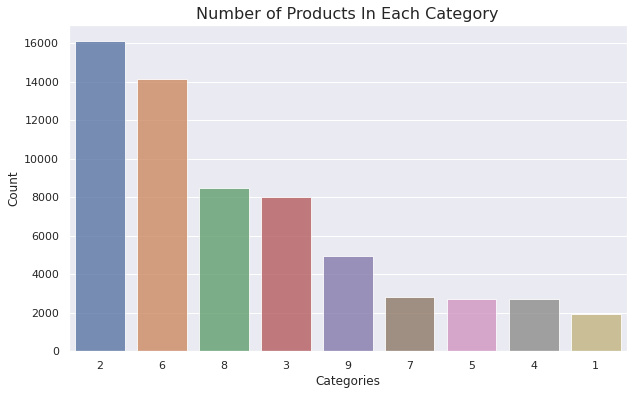

In [0]:
# Plotting a bar chart for the target values
category_count = df.target.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(category_count.index, category_count.values,
            order=category_count.index,
            alpha=0.8)
plt.title('Number of Products In Each Category', fontdict={'fontsize': 16})
plt.ylabel('Count')
plt.xlabel('Categories', fontdict={'fontsize': 12});

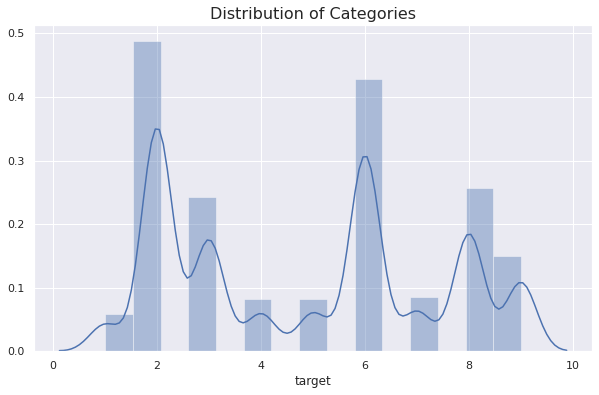

In [0]:
# Visualize distribution

plt.figure(figsize=(10,6))
sns.distplot(df.target, bins=15)
plt.title('Distribution of Categories', fontdict={'fontsize': 16});

### Split the Training Data into Sets

I want to split the training data into 3 sets:

* training data (for training the model)
* validation data (for tuning hyperparameters)
* test data (for evaluating the model without bias)

Kaggle provides a "test set", but that's the data which you have to submit to Kaggle for scoring.

The competition is finished, but the organizers haven't made the labels for the "test set" public.

For splitting data into 3 sets, see [Stackoverflow: How to split data into 3 sets (train, validation and test)?](https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213).

In [0]:
# Helper function for splitting data

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [0]:
# Split data into sets
np.random.seed(42)

X = df.drop(['id', 'target'], axis=1)
y = df.target

train, validate, test = train_validate_test_split(df)

X_train, y_train = train.drop(['id', 'target'], axis=1), train.target
X_val, y_val = validate.drop(['id', 'target'], axis=1), validate.target
X_test, y_test = test.drop(['id', 'target'], axis=1), test.target
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((37126, 93), (12375, 93), (12377, 93), (37126,), (12375,), (12377,))

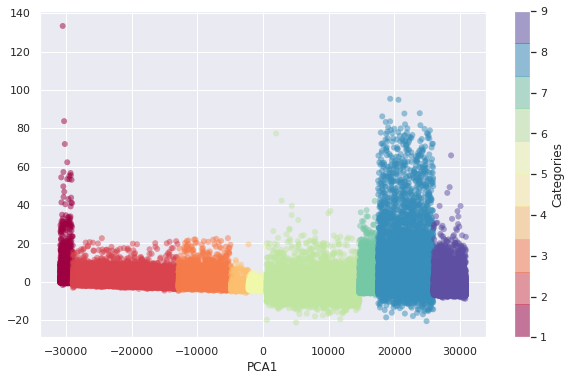

In [0]:
# Visualize dataset with PCA

# instantiate model with 2 dimensions
pca = PCA(2)

# project from 93 to 2 dimensions
projected = pca.fit_transform(df)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.colorbar(label='Categories');

The full data is a 93-dimensional point cloud. These points are the projection of each data point along the directions with largest variance.

See [Principal Component Analysis (Data Science Handbook)](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

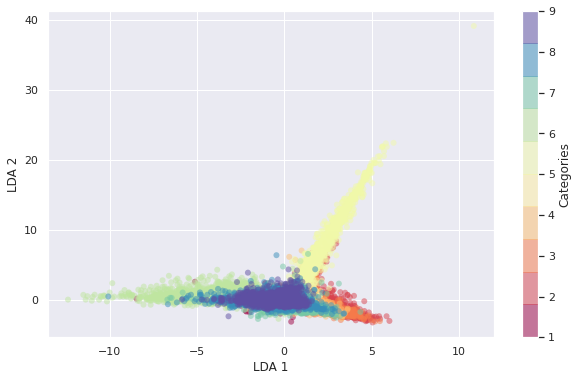

In [0]:
# Visualize dataset with LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# instantiate model with 2 dimensions
lda = LinearDiscriminantAnalysis(n_components=2)

# project from 93 to 2 dimensions
projected = lda.fit_transform(X, y)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.colorbar(label='Categories');

## 5. Data Modelling

### Dimensionality Reduction with PCA

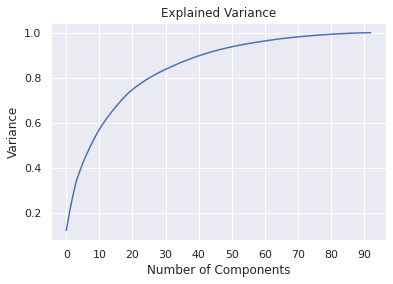

In [0]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 100, step=10))
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Explained Variance');

**Note**: With 80 components, we preserve almost 100% of the total variance of the data.

In [0]:
# Reduce dimensionality with PCA

# Create PCA
pca = PCA(n_components=80, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)

X_train_pca.shape, X_val_pca.shape

((37126, 80), (12375, 80))

### Naive Gaussian Bayes

In [0]:
# Instantiate Gaussian Naive Bayes and fit
np.random.seed(42)
naive_bayes_pca_clf = GaussianNB().fit(X_train_pca, y_train)

#### Create An Evaluation Helper Function

In [0]:
# Create k-fold cross-validation
skf = StratifiedKFold(n_splits=6,
                      shuffle=True,
                      random_state=42)

# Create a dictionary of scoring metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted'),
           'log_loss': 'neg_log_loss'}

# Create helper function for cross-validated scores
def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=skf):
    """
    Evaluates a given model/estimator using cross-validation
    and returns a dict containing the absolute vlues of the average (mean) scores
    for classification models.

    clf: scikit-learn classification model
    X: features (no labels)
    y: labels
    scoring: a dictionary of scoring metrics
    cv: cross-validation strategy
    """
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=skf, n_jobs=-1)
    
    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}

In [0]:
# Score model
naive_bayes_pca_metrics = average_score_on_cross_val_classification(naive_bayes_pca_clf, X, y)
naive_bayes_pca_metrics

{'fit_time': 0.14623,
 'score_time': 0.13698,
 'test_accuracy': 0.61495,
 'test_f1': 0.62373,
 'test_log_loss': -7.36627,
 'test_precision': 0.6697,
 'test_recall': 0.61495}

In [0]:
# Make predictions
y_preds_naive_bayes_pca = naive_bayes_pca_clf.predict(X_val_pca)
y_preds_naive_bayes_proba_pca = naive_bayes_pca_clf.predict_proba(X_val_pca)

In [0]:
# Multi-class log loss on predictions
log_loss(y_val, y_preds_naive_bayes_proba_pca)

9.930282677416743

**Note**: In the competition, the best score was 0.38242!
Naive Gaussian Bayes doesn't do well here!

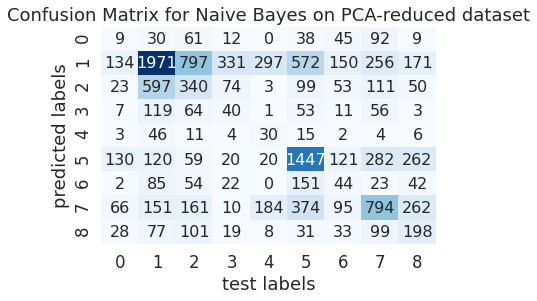

In [0]:
# Confusion Matrix
naive_bayes_pca_conf_mat = confusion_matrix(y_val, y_preds_naive_bayes_pca)

sns.set(font_scale=1.5)
sns.heatmap(naive_bayes_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Naive Bayes on PCA-reduced dataset');

### Random Forest Classification

In [0]:
# Initialize and fit Random Forest Classifier
rf_pca_clf = RandomForestClassifier(max_samples=8000,
                                    random_state=42).fit(X_train_pca, y_train)

In [0]:
# Show scores
rf_pca_metrics = average_score_on_cross_val_classification(rf_pca_clf, X, y)
rf_pca_metrics

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'fit_time': 4.28667,
 'score_time': 0.59074,
 'test_accuracy': 0.78474,
 'test_f1': 0.76797,
 'test_log_loss': -0.67992,
 'test_precision': 0.7873,
 'test_recall': 0.78474}

In [0]:
# Create predictions
y_preds_rf_pca = rf_pca_clf.predict(X_val_pca)
y_preds_rf_proba_pca = rf_pca_clf.predict_proba(X_val_pca)

In [0]:
log_loss(y_val, y_preds_rf_proba_pca)

1.8878895991007871

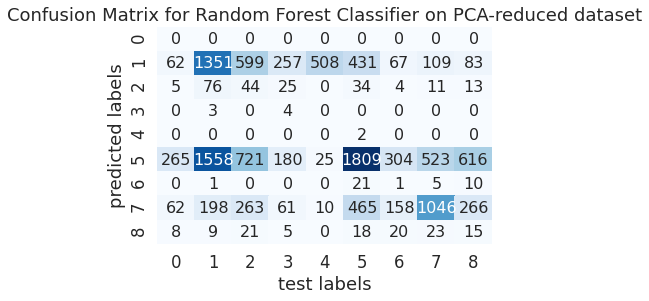

In [0]:
# Confusion Matrix
rf_pca_conf_mat = confusion_matrix(y_val, y_preds_rf_pca)

sns.set(font_scale=1.5)
sns.heatmap(rf_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Random Forest Classifier on PCA-reduced dataset');

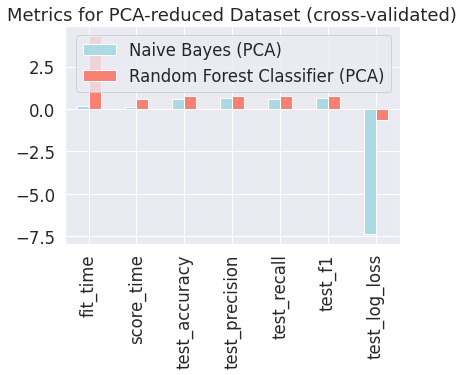

In [0]:
# Visualize cross-validated metrics
compare_metrics_df = pd.DataFrame({'Naive Bayes (PCA)': naive_bayes_pca_metrics,
                                   'Random Forest Classifier (PCA)': rf_pca_metrics},
                                  index=naive_bayes_pca_metrics.keys())

compare_metrics_df.plot(title='Metrics for PCA-reduced Dataset (cross-validated)',
                        color=['lightblue', 'salmon'],
                        kind='bar');

### Experiments With Feature Engineering

In [0]:
# let's look at the different number of labels in each variable (cardinality)

# columns in the dataset without target and id
data = df.drop(['id', 'target'], axis=1)

cat_cols = data.columns

for col in cat_cols:
    print('variable: ', col, ' number of labels: ', X[col].nunique())

print('total products: ', len(X))

variable:  feat_1  number of labels:  42
variable:  feat_2  number of labels:  37
variable:  feat_3  number of labels:  48
variable:  feat_4  number of labels:  59
variable:  feat_5  number of labels:  15
variable:  feat_6  number of labels:  9
variable:  feat_7  number of labels:  30
variable:  feat_8  number of labels:  55
variable:  feat_9  number of labels:  40
variable:  feat_10  number of labels:  26
variable:  feat_11  number of labels:  28
variable:  feat_12  number of labels:  20
variable:  feat_13  number of labels:  51
variable:  feat_14  number of labels:  32
variable:  feat_15  number of labels:  37
variable:  feat_16  number of labels:  28
variable:  feat_17  number of labels:  40
variable:  feat_18  number of labels:  30
variable:  feat_19  number of labels:  105
variable:  feat_20  number of labels:  27
variable:  feat_21  number of labels:  15
variable:  feat_22  number of labels:  21
variable:  feat_23  number of labels:  24
variable:  feat_24  number of labels:  66
v

#### Linear Discriminant Analysis

Find out how many components are required to get above 0.95 variance threshold.

See also [Chris Albon's notes](https://chrisalbon.com/machine_learning/feature_engineering/lda_for_dimensionality_reduction/).

From [Machine Learning Mastery](https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/):
> Logistic regression is a simple and powerful linear classification algorithm. It also has limitations that suggest at the need for alternate linear classification algorithms.

> * **Two-Class Problems**. Logistic regression is intended for two-class or binary classification problems. It can be extended for multi-class classification, but is rarely used for this purpose.
> * **Unstable With Well Separated Classes**. Logistic regression can become unstable when the classes are well separated.
> * **Unstable With Few Examples**. Logistic regression can become unstable when there are few examples from which to estimate the parameters.

> Linear Discriminant Analysis does address each of these points and is the go-to linear method for multi-class classification problems. Even with binary-classification problems, it is a good idea to try both logistic regression and linear discriminant analysis.

In [0]:
# Create and fit LDA
lda = LinearDiscriminantAnalysis(n_components=None)
features_lda = lda.fit(X_train, y_train)

# Create array of explained variance rations
lda_var_ratios = lda.explained_variance_ratio_

In [0]:
# Function for selecting n components
def select_n_lda_components(var_ratio, goal_var):
    # Set initial variance
    total_variance = 0.0
    # Set initial number of components
    n_components = 0
    # loop
    for explained_variance in var_ratio:
        # Add explained variance to total
        total_variance += explained_variance
        # Increment number of components
        n_components += 1
        # Stop loop if goal level of explained variance is met
        if total_variance >= goal_var:
            break
    
    return n_components

In [0]:
lda_components = select_n_lda_components(lda_var_ratios, 0.95)
lda_components

5

#### Truncated Singular Value Decomposition (TSVD)

The dataset shows that this challenge provides a **sparse feature matrix**.

_Truncated SVD_ is an ideal candidate:

From the [sci-kit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html):

> This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently

See also [Chris Albon's notes](https://chrisalbon.com/machine_learning/feature_engineering/dimensionality_reduction_on_sparse_feature_matrix/).

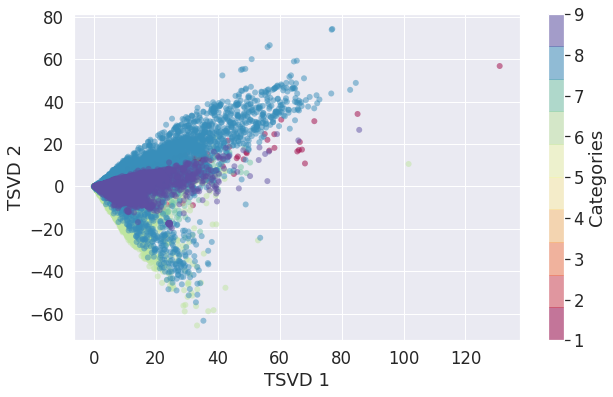

In [0]:
# Visualize dataset with TSVD

# instantiate model with 2 dimensions
tsvd = TruncatedSVD(n_components=2)

# project from 93 to 2 dimensions
projected = tsvd.fit_transform(X, y)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('TSVD 1')
plt.ylabel('TSVD 2')
plt.colorbar(label='Categories');

In [0]:
# Standardize features
X_train_std = StandardScaler().fit_transform(X_train)
X_val_std = StandardScaler().fit_transform(X_val)

In [0]:
# Create and run TSVD with one less than number of (sparse) features
tsvd = TruncatedSVD(n_components=X_train_std.shape[1]-1)
features_tsvd = tsvd.fit(X_train_std)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [0]:
# Create a function
def select_n_tsvd_components(var_ratio, goal_var):
    # Set initial variance
    total_variance = 0.0
    # Set initial number of components
    n_components = 0
    # loop
    for explained_variance in var_ratio:
        # Add explained variance to total
        total_variance += explained_variance
        # Increment number of components
        n_components += 1
        # Stop loop if goal level of explained variance is met
        if total_variance >= goal_var:
            break
    
    return n_components 

In [0]:
tsvd_components = select_n_tsvd_components(tsvd_var_ratios, 0.95)
tsvd_components

77

### Create Pipeline And Compare Different Models

In [0]:
# Create features union
# Standardizes features, runs TSVD with best number of components, select 6 kbest features
features = []
features.append(('standardize', StandardScaler()))
features.append(('tsvd', TruncatedSVD(n_components=tsvd_components)))
features.append(('select best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

In [0]:
# Create pipeline
# combines feature union with scikit-learn estimator

# Logistic Regression
estimators_log_r =  []
estimators_log_r.append(('feature_union', feature_union))
estimators_log_r.append(('logistic', LogisticRegression(max_iter=5000, random_state=42)))
model_log_r = Pipeline(estimators_log_r)

# SVC
estimators_svc = []
estimators_svc.append(('feature_union', feature_union))
estimators_svc.append(('svc', SVC(probability=True, random_state=42)))
model_svc = Pipeline(estimators_svc)

# Random Forest
estimators_rf = []
estimators_rf.append(('feature_union', feature_union))
estimators_rf.append(('rf', RandomForestClassifier(n_jobs=-1, random_state=42)))
model_rf = Pipeline(estimators_rf)

models = {'Logistic_Regression': model_log_r,
          'SVC': model_svc,
          'Random_Forest_C': model_rf}

In [0]:
# Fit models
%%time

for name, model in models.items():
  print('Fitting model: ', name)
  model.fit(X_train, y_train)
  print(name, ': done.')

Fitting model:  Logistic_Regression
Logistic_Regression : done.
Fitting model:  SVC
SVC : done.
Fitting model:  Random_Forest_C
Random_Forest_C : done.
CPU times: user 15min 11s, sys: 37.5 s, total: 15min 49s
Wall time: 14min 15s


In [0]:
# Make predictions
models_preds_proba = {name: model.predict_proba(X_val) for name, model in models.items()}

In [0]:
# Compute log loss function
models_log_loss = {model_name: log_loss(y_val, proba_predictions) for model_name, proba_predictions in models_preds_proba.items()}
models_log_loss

{'Logistic_Regression': 0.6600080556833081,
 'Random_Forest_C': 0.6587399591983326,
 'SVC': 0.588920524382502}

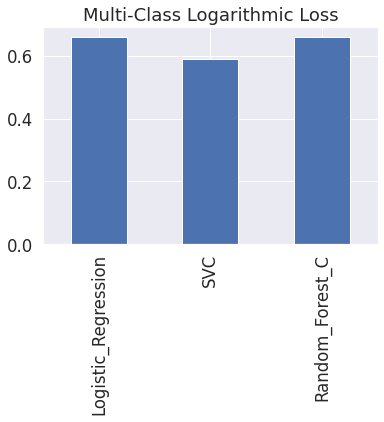

In [0]:
# Visualize metrics

# Create Dataframe
models_log_loss_df = pd.DataFrame(models_log_loss, index=['Log Loss']).T

# Plot
models_log_loss_df.plot(title='Multi-Class Logarithmic Loss',
                        legend=False,
                        kind='bar');

**Note**: It seems like Support Vector Machine scores the best on the dataset.

### Explore Support Vector Machine

In [0]:
# preprocess data
def preprocess_data(X, y,tsvd_components=tsvd_components, kbest=6):
  """
  Runs preprocessing steps on the data.

  X: features
  y: labels
  tsvd_compenents: number of n_components for TSVD
  kbest: number of best features to select
  """
  # StandardScaler 
  scaler = StandardScaler()
  std_features = scaler.fit_transform(X)

  # TSVD
  svd = TruncatedSVD(n_components=tsvd_components, random_state=42)
  svd_features = svd.fit_transform(std_features)

  # Kbest
  kb = SelectKBest(k=kbest)
  features = kb.fit_transform(X, y)

  return features

In [0]:
X_preproc = preprocess_data(X_train, y_train)
X_preproc.shape

(37126, 6)

In [0]:
# Create model
svc = SVC(probability=True,
          class_weight='balanced',
          random_state=42)

# Create space of candidate values
search_space = [{'C': [0.001, 0.01, 0.1, 1],
                 'gamma': ['scale', 0.1, 1]}]

# Create Random Search
model = RandomizedSearchCV(svc,
                           search_space,
                           n_iter=5,
                           cv=3,
                           scoring='neg_log_loss',
                           verbose=True,
                           n_jobs=-1)

In [0]:
# Conduct Search on small subset of training data
%%time

best_model = model.fit(X_preproc[:5000], y_train[:5000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.2s finished


CPU times: user 6 s, sys: 44.7 ms, total: 6.04 s
Wall time: 51.1 s


In [0]:
# View best params
print('Best C: ', best_model.best_estimator_.get_params()['C'])
print('Best gamma: ', best_model.best_estimator_.get_params()['gamma'])

Best C:  1
Best gamma:  0.1


### Build SVC Model Pipeline With Hyper-Tuned Parameters

In [0]:
# Create features union
# Standardizes features, runs TSVD with best number of components, select 6 kbest features
features = [('standardize', StandardScaler()),
            ('tsvd', TruncatedSVD(n_components=tsvd_components)),
            ('select best', SelectKBest(k=6))]
            
feature_union = FeatureUnion(features)

In [0]:
# Create pipeline
# combines feature union with scikit-learn estimator

# SVC
estimators_svc = [('feature_union', feature_union),
                  ('svc', SVC(probability=True,
                              class_weight='balanced',
                              C=1.0,
                              gamma=0.1,
                              random_state=42))]

model = Pipeline(estimators_svc)

In [0]:
# Fit model
%%time

model.fit(X_train, y_train)

CPU times: user 1h 49min 4s, sys: 4.91 s, total: 1h 49min 9s
Wall time: 1h 49min 13s


Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('standardize',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('tsvd',
                                                 TruncatedSVD(algorithm='randomized',
                                                              n_components=77,
                                                              n_iter=5,
                                                              random_state=None,
                                                              tol=0.0)),
                                                ('select best',
                                                 SelectKBest(k=6,
                       

### Save model

In [0]:
import pickle

In [0]:
# Save model
if os.getenv('COLAB'):
  pickle.dump(model, open('/content/drive/My Drive/Colab Notebooks/models/kaggle-otto-model-2.pkl', 'wb'))
else:
  pickle.dump(model, open('../../data/kaggle-otto-model-2.pkl', 'wb'))

In [0]:
# Import model
if os.getenv('COLAB'):
  model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/models/kaggle-otto-model-2.pkl', 'rb'))
else:
  model = pickle.log(open('../../data/kaggle-otto-model-2.pkl', 'rb'))

#### Make Predictions on Test Data

In [0]:
# Make predictions on subset of data
y_preds = model.predict(X_test[:5000])
y_preds_proba = model.predict_proba(X_test)

In [0]:
# check logarithmic loss metric
log_loss(y_true=y_test, y_pred=y_preds_proba)

1.3549257118503082

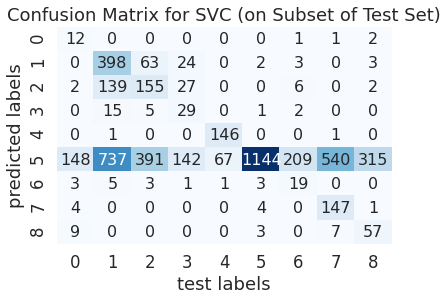

In [0]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test[:5000], y_preds)
sns.set(font_scale=1.5)
sns.heatmap(conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for SVC (on Subset of Test Set)');

### Make Predictions On Submission Data

In [0]:
model.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [0]:
# Drop id column, so data shapes line up
df_submit = df_submission.drop('id', axis=1)

In [0]:
y_preds_proba = model.predict_proba(df_submit)

In [0]:
# Take a look at sample submission file
if os.getenv('COLAB'):
  sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/otto/sampleSubmission.csv')
else:
  sample_submission = pd.read_csv('../../data/otto/sampleSubmission.csv')
  
sample_submission.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,1,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0


In [0]:
# Create submission DataFrame
predictions = pd.DataFrame(y_preds_proba,
                           columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'],
                           index=df_submission.id)
predictions.reset_index()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.032487,0.175258,0.098992,0.041232,0.005469,0.349497,0.054234,0.150474,0.092356
1,2,0.033154,0.146953,0.083486,0.031705,0.005431,0.382701,0.054641,0.162959,0.098971
2,3,0.033154,0.146952,0.083485,0.031705,0.005431,0.382705,0.054640,0.162958,0.098970
3,4,0.033142,0.147483,0.083798,0.031740,0.005430,0.382149,0.054629,0.162773,0.098857
4,5,0.033176,0.146312,0.082809,0.031687,0.005437,0.381928,0.054613,0.162714,0.101324
...,...,...,...,...,...,...,...,...,...,...
144363,144364,0.050106,0.140115,0.075592,0.030587,0.005370,0.378429,0.054027,0.159868,0.105905
144364,144365,0.001444,0.278833,0.521982,0.177712,0.000949,0.002207,0.014187,0.001611,0.001075
144365,144366,0.033144,0.147043,0.084604,0.031715,0.005430,0.381924,0.054637,0.162711,0.098792
144366,144367,0.011844,0.345369,0.174104,0.403188,0.003206,0.012041,0.028492,0.011289,0.010468


In [0]:
# Save predictions to Google Drive
if os.getenv('COLAB'):
  predictions.to_csv('/content/drive/My Drive/Colab Notebooks/data/otto/submit-2.csv')
else:
  predictions.to_csv('../../data/otto/submit-2.csv')

**Note**: My initial workflow had a terrible error in reducing the number of features on which to train the model. That resulted in overfitting the model. I had a fabulous score on the training data, but a disastrous score on the submission data (aroud 8.19).

The current submission is trainend on 77 features (reduced with TSVD) and scores 1.35 with the test data.
Kaggle scores the model with 1.34 on the submission data.

While this is a vast improvement over the original model, my version still scores significantly lower than the top submissions (around 0.38).

**Learning Recap**: I learned about 

* feature reduction with different techniques (LDA, PCA, TSVD)
* feature extraction and modelling pipeline
* visualization methods with `seaborn`
* what to do against overfitting a model
* writing custom scoring methods with `make_scorer` and `cross_validate`